This notebook runs the same codes as `nnt_final.ipynb` but with 150 neurons in each hidden layer and using 150 principal components of the training data. (see below for number of components)

In [1]:
# the folder name to which to save all output
dir_name = "nnt_final5_output/"

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

from scipy import stats

import theano
floatX = theano.config.floatX 
import theano.tensor as T 
import pymc3 as pm

import matplotlib.pyplot as plt 
from pipetools import pipe # similar to pipe operator in R 
import seaborn as sns

import pickle

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [5]:
# Download MNIST data from mldata.org

import tempfile
mnist_home = tempfile.mkdtemp()
mnist = fetch_mldata("MNIST original", data_home = mnist_home)

print(mnist.data.shape) # 70,000 observations with 28*28 pixels 
print(mnist.target.shape) # 70,000 targets 

(70000, 784)
(70000,)


In [7]:
# Divide the data into X matrix and Y matrix 

def get_mnist_X_Y(mnist):
    X = mnist.data 
    Y = mnist.target
    k = len(np.unique(Y)) # the number of categories, which is 10 
    n = X.shape[0] # the number of observations 
    
    X = (X - X.min())  / (X.max() - X.min()) # scaling data
    
    print("Number of images: ", n)
    return X, Y

X, Y = get_mnist_X_Y(mnist)
print("X shape is {} \n Y shape is {}".format(X.shape, Y.shape))

Number of images:  70000
X shape is (70000, 784) 
 Y shape is (70000,)


In [8]:
# Transform X matrix into rank-150 matrix using principal component analysis
pca = PCA(n_components = 150, svd_solver = "randomized")
X_pca = pca.fit_transform(X)

In [22]:
# Split the data into training and testing sets for both X and Y matrices (both versions)
X_tr_orig, X_ts_orig, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.1, random_state=1)
X_tr_pca, X_ts_pca, Y_tr, Y_ts = train_test_split(X_pca, Y, test_size=0.1, random_state=1)
X_tr, X_ts = X_tr_pca, X_ts_pca

print("X_tr shape is {} \n Y_tr shape is {}".format(X_tr.shape, Y_tr.shape))
print("X_ts shape is {} \n Y_ts shape is {}".format(X_ts.shape, Y_ts.shape))

X_tr shape is (63000, 150) 
 Y_tr shape is (63000,)
X_ts shape is (7000, 150) 
 Y_ts shape is (7000,)


In [23]:
def construct_nnet(nnt_input, nnt_out, hidden1, hidden2):
    """
    Data 
    ===========
    nnt_input: theano tensor shared variable 
        the input matrices converted into shared variable by theano.shared()
    
    nnt_out: shared variable
        the output matrix converted into shared variable by theano.shared()
        
    hidden1: int
        the number of perceptrons in hidden layer 1
    
    hidden2: int
        the number of perceptrons in hidden layer 2 
        
    K: int
        shape parameter in the gamma distribution for sigma2
        
    v: float
        scale parameter in the gamma distribution for sigma2 
        
    Parameters
    ==========
    sigma 2: float
        the error variance 
    
    w0, b0: float
        weight and bias from input to hidden layer 1
    
    w1, b1: float
        weight and bias from hidden layer 1 to hidden layer 2
    
    w2, b2: float
        weight and bias from hidden layer 2 to output 
    
    """
    K = 5 
    v = 0.2
    #K_share = theano.shared(K)
    #v_share = theano.shared(v)
    
    
    
    # initialize parameters
    #sigma2 = np.random.gamma(shape=(0.05/K**(1/v))**2, scale=v, size=1).astype(floatX) 
    sigma2 = np.random.gamma(shape = K, scale = v, size = 1).astype(floatX) 
    w0 = np.random.normal(loc = 0, scale = np.sqrt(1.0/sigma2), size = (X_tr.shape[1], hidden1)).astype(floatX)
    b0 = np.random.normal(loc = 0, scale = np.sqrt(1.0/sigma2), size = hidden1).astype(floatX) 
    w1 = np.random.normal(loc = 0, scale = np.sqrt(1.0/sigma2), size = (hidden1, hidden2)).astype(floatX)
    b1 = np.random.normal(loc = 0, scale = np.sqrt(1.0/sigma2), size = hidden2).astype(floatX)
    w2 = np.random.normal(loc = 0, scale = np.sqrt(1.0/sigma2), size = (hidden2, 10)).astype(floatX)
    b2 = np.random.normal(loc = 0, scale = np.sqrt(1.0/sigma2), size = 10).astype(floatX) 
    
    with pm.Model() as neural_net:
        
        # set prior for the parameters 
        s2 = pm.Gamma("s2", alpha = K, beta = v, shape = 1, testval = sigma2)
        weight_0 = pm.Normal("w0", 0, sd = T.sqrt(1.000001/s2),
                                     shape = (X_tr.shape[1], hidden1), testval = w0)
        weight_1 = pm.Normal("w1", 0, sd = T.sqrt(1.000001/s2),
                                     shape=(hidden1, hidden2), testval=w1)
        weight_2 = pm.Normal("w2", 0, sd = T.sqrt(1.000001/s2), 
                                    shape = (hidden2, 10), testval = w2)
        bias_0 = pm.Normal("b0",  0, sd = T.sqrt(1.000001/s2),
                                     shape=hidden1, testval=b0)
        bias_1 = pm.Normal("b1",  0, sd=T.sqrt(1.000001/s2),
                                 shape=hidden2, testval=b1)
        bias_2 = pm.Normal("b2",  0, sd=T.sqrt(1.000001/s2),
                                 shape=10, testval=b2) 
        
        # build neural network using tanh function
        act_1 = pm.math.tanh(pm.math.dot(nnt_input, weight_0) + bias_0)
        act_2 = pm.math.tanh(pm.math.dot(act_1, weight_1) + bias_1)
        act_mu = pm.math.dot(act_2, weight_2) + bias_2
        act_out = T.nnet.softmax(act_mu)
        
        # likelihood --> categorical likelihood 
        out = pm.Categorical("out",
                            act_out,
                            observed=nnt_out,
                            total_size=Y_tr.shape[0])
        
    return neural_net


In [24]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

set_tt_rng(MRG_RandomStreams(2)) # similar to set.seed() in R 

In [26]:
%%time

nnt_input = theano.shared(X_tr) # convert X_tr to shared variable 
nnt_out  = theano.shared(Y_tr) # convert Y_tr to shared Variable


# Run neural network with 150 neutrons
neural_network = construct_nnet(nnt_input, nnt_out, hidden1 = 150, hidden2 = 150)

from pymc3.backends import SQLite

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n = 6000, method = inference)
    #db = SQLite('trace.db')
    #trace_save = pm.sample(draws=3000, trace=db)

Average Loss = 1.4969e+05: 100%|██████████| 6000/6000 [2:23:40<00:00,  1.44s/it]  
Finished [100%]: Average Loss = 1.495e+05


CPU times: user 3h 3min 46s, sys: 22min 35s, total: 3h 26min 21s
Wall time: 2h 24min 27s


In [27]:
trace = approx.sample(draws = 3000)

In [28]:
print(trace.varnames)
for parameters in trace.varnames:
    print(trace[parameters].shape)

['s2_log__', 'w0', 'w1', 'w2', 'b0', 'b1', 'b2', 's2']
(3000, 1)
(3000, 150, 150)
(3000, 150, 150)
(3000, 150, 10)
(3000, 150)
(3000, 150)
(3000, 10)
(3000, 1)


In [29]:
trace_summary = pm.summary(trace)
print(trace_summary)

              mean        sd  mc_error   hpd_2.5  hpd_97.5
w0__0_0  -1.127189  0.597962  0.012636 -2.234343  0.083735
w0__0_1   0.624310  0.623155  0.011212 -0.554791  1.922804
w0__0_2   1.344592  0.531510  0.009281  0.309459  2.330507
w0__0_3  -1.232747  0.569496  0.010102 -2.249463 -0.056102
w0__0_4   0.440546  0.632800  0.012139 -0.782906  1.669043
w0__0_5  -2.787658  0.533234  0.009536 -3.781155 -1.752358
w0__0_6   0.843364  0.528171  0.009560 -0.249547  1.786589
w0__0_7   0.201997  0.586442  0.009767 -0.937646  1.328180
w0__0_8  -1.335594  0.599519  0.009646 -2.531154 -0.157713
w0__0_9   0.009458  0.662673  0.013569 -1.265706  1.266410
w0__0_10 -0.725761  0.568058  0.009205 -1.819006  0.408331
w0__0_11  1.024855  0.574544  0.009243 -0.150461  2.094439
w0__0_12 -0.600854  0.620731  0.010804 -1.806280  0.588560
w0__0_13  1.458399  0.583157  0.011048  0.291389  2.561316
w0__0_14 -0.261480  0.563010  0.010209 -1.399504  0.781187
w0__0_15  0.449902  0.561818  0.011193 -0.618182  1.5707

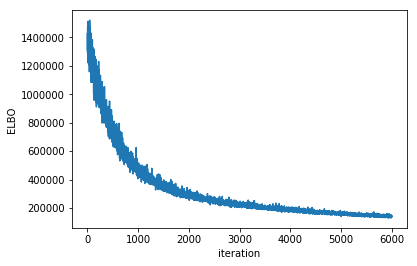

In [30]:
# plot evidence lower bound (ELBO)
name = dir_name + "ELBO.png"
plt.plot(inference.hist)
plt.ylabel("ELBO")
plt.xlabel("iteration")
plt.savefig(name)
plt.show()

In [31]:
x = T.matrix("X")
n = T.iscalar("n") 
#x.tag.test_value = np.empty_like(X_tr[:10])
x.tag.test_value = np.empty_like(X_tr)
n.tag.test_value = 100

_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size = n,
                                   more_replacements = {nnt_input: x})
# compile the function
sample_proba = theano.function([x, n], _sample_proba)

pred = sample_proba(X_ts, 500).mean(axis = 0)
Y_pred = pred.argmax(axis=1)

# prediction accuracy
print('Accuracy = {}%'.format((Y_ts == Y_pred).mean() * 100))

Accuracy = 92.58571428571429%


In [32]:
name = dir_name + "pred.pickle"

output = {'pred': pred}
with open(name, 'wb') as f:
    pickle.dump(output, f, pickle.HIGHEST_PROTOCOL)

In [44]:
# Run if already have "pred.pickle"

pred = pickle.load( open(dir_name + "pred.pickle", "rb" ) )['pred']
Y_pred = pred.argmax(axis=1)

In [33]:
# Which handwritings did our B-NNT get wrong? 
pred_wrong = [i for i in range(len(Y_pred)) if Y_ts[i] != Y_pred[i]] 

"""
Create a dictionary where the keys refer to the predicted number and the 
values for each key are the indices of observations predicted as that number by B-NNT
"""

k = len(range(10))
pred_dict = dict.fromkeys(range(k))
for j in range(k):
    pred_dict[j] = [obs for obs in pred_wrong if Y_ts[obs] == j]

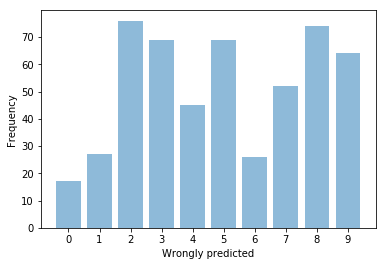

There were 17 instances of 0's predicted incorrectly.
There were 27 instances of 1's predicted incorrectly.
There were 76 instances of 2's predicted incorrectly.
There were 69 instances of 3's predicted incorrectly.
There were 45 instances of 4's predicted incorrectly.
There were 69 instances of 5's predicted incorrectly.
There were 26 instances of 6's predicted incorrectly.
There were 52 instances of 7's predicted incorrectly.
There were 74 instances of 8's predicted incorrectly.
There were 64 instances of 9's predicted incorrectly.


In [47]:
# Is there any pattern to the way B-NNT got the predictions wrong?
count = []
for key in pred_dict.keys():
    count.append(len(pred_dict[key]))

name = dir_name + "freq_wrong_pred.png"
plt.bar(pred_dict.keys(), count, align='center', alpha=0.5)
plt.ylabel('Frequency')
plt.xlabel("Wrongly predicted")
plt.xticks(np.arange(10), ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
#plt.title("Frequency of Wrong Predictions")
plt.savefig(name)
plt.show()
for i,j in enumerate(count): 
    print("There were {} instances of {}'s predicted incorrectly.".format(j, i))

In [35]:
"""
Create a table whose row number refers to the actual digit and the
column number to the predicted digit. The entry records the number
of observations. 

e.g. The entry in the 2nd row and 3rd column is the number of observations whose
actual digits were "2" but which our NNT predicted as being "3". 
""" 

tab = np.zeros((k, k))
for key, value in pred_dict.items():
    y = Y_pred[value]
    tab[key, :] = [int(sum(y == k)) for k in range(k)]
    tab.astype(int)
print(tab)

[[  0.   0.   2.   1.   0.   4.   6.   0.   4.   0.]
 [  0.   0.   3.   5.   0.   4.   1.   3.   9.   2.]
 [  9.   3.   0.   8.  13.   2.  11.  12.  15.   3.]
 [  2.   4.  17.   0.   1.  14.   5.   9.  13.   4.]
 [  1.   4.   2.   0.   0.   0.   9.   2.   3.  24.]
 [  7.   1.   1.  10.  10.   0.  12.   5.  17.   6.]
 [  2.   1.   3.   0.   6.   9.   0.   2.   3.   0.]
 [  2.   7.  14.   0.   7.   1.   0.   0.   1.  20.]
 [  7.  11.   6.  13.   2.  14.   9.   1.   0.  11.]
 [  7.   1.   2.  13.  11.   1.   0.  24.   5.   0.]]


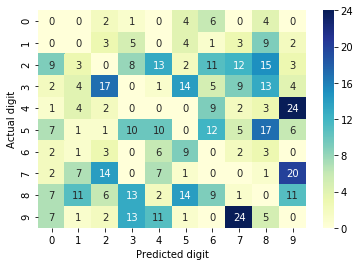

In [36]:
# create a heatmap of which kinds of digits had the high error rate 
name = dir_name + "heatmap.png"


sns_hmap = sns.heatmap(tab, cmap="YlGnBu", annot=True)
plt.ylabel("Actual digit")
plt.xlabel("Predicted digit")
fig = sns_hmap.get_figure()
fig.savefig(name)
plt.show()



In [39]:
import random

def inspect_pred(digit, pred, howmany = None, printL = False):
    name = dir_name + "predict_" + str(digit) + "_as_" + str(pred) + ".png"
    if digit != pred:
        L = sorted([obs for obs in pred_dict[digit] if Y_pred[obs] == pred])
    if (digit == pred) & (howmany != None):
        C = [i for i in range(len(Y_pred)) if (Y_pred[i] == digit) & (Y_ts[i] == pred)] 
        L = sorted(random.sample(C, howmany))
    num_rows, num_cols = 2, int(len(L)/2)+ len(L)%2
    fig = plt.figure(figsize = (num_cols, 2*num_rows))
    for obs in L:
        plt.subplot(num_rows, num_cols, L.index(obs) + 1)
        plt.imshow(X_ts_orig[obs].reshape(28,28), cmap='gray') # show the ith target value acc. to the pixel info 
        plt.title(obs)
    fig.savefig(name)
    plt.show()
    if (printL == True): print(L)

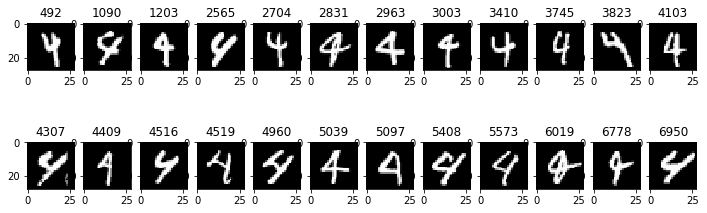

[492, 1090, 1203, 2565, 2704, 2831, 2963, 3003, 3410, 3745, 3823, 4103, 4307, 4409, 4516, 4519, 4960, 5039, 5097, 5408, 5573, 6019, 6778, 6950]


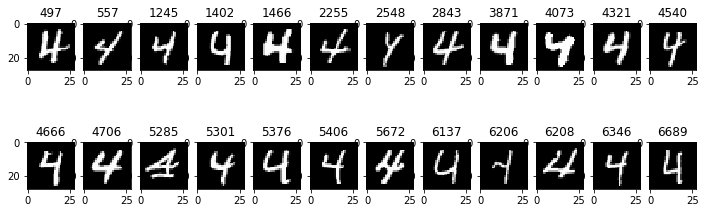

In [41]:
# Inspect the actual handwritings of "4" that were incorrectly predicted as "9".
inspect_pred(digit = 4, pred = 9, printL = True)
# Inspect the actual handwritings of "4" that were correctly predicted as "4".
inspect_pred(digit = 4, pred = 4, howmany = 24, printL = False)

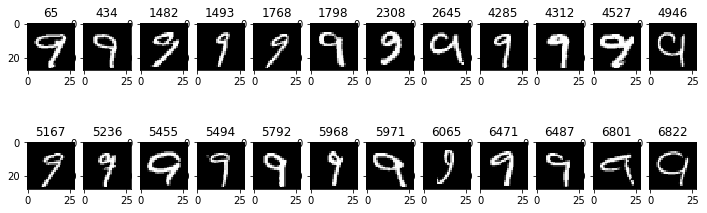

[65, 434, 1482, 1493, 1768, 1798, 2308, 2645, 4285, 4312, 4527, 4946, 5167, 5236, 5455, 5494, 5792, 5968, 5971, 6065, 6471, 6487, 6801, 6822]


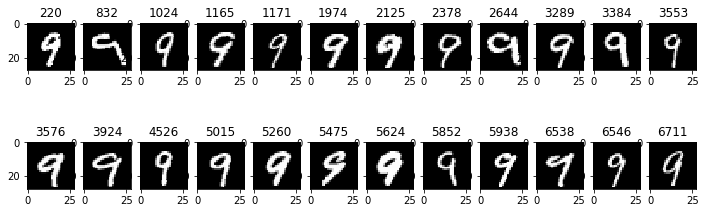

In [42]:
# Inspect the actual handwritings of "7" that were incorrectly predicted as "9".
inspect_pred(digit = 9, pred = 7, printL = True)
inspect_pred(digit = 9, pred = 9, howmany = 24)

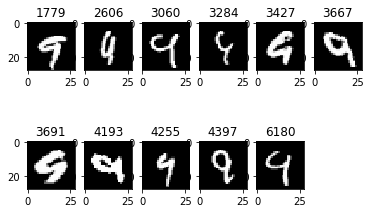

In [43]:
# Inspect the actual handwritings of "9" that were incorrectly predicted as "4".
inspect_pred(digit = 9, pred = 4)


In [44]:
%%time
name = dir_name + "trace_summary.pickle"
with open(name, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(trace_summary, f, pickle.HIGHEST_PROTOCOL)


CPU times: user 12.4 ms, sys: 7.38 ms, total: 19.8 ms
Wall time: 18.7 ms


In [45]:
%%time
name = dir_name + "approx.pickle"
with open(name, 'wb') as f:
    pickle.dump(approx, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 468 ms, sys: 1.13 s, total: 1.6 s
Wall time: 2.09 s


In [46]:
# Note: already saved trace_w0.txt. The code below saves the traces of other parameters 
for parameters in trace.varnames:
    name = dir_name + "trace_" + parameters + ".txt"
    a = trace[parameters]
    a.tofile(name, sep = " ", format = "%s")
    print("Saved file: {}".format(name))

Saved file: nnt_final5_output/trace_s2_log__.txt
Saved file: nnt_final5_output/trace_w0.txt
Saved file: nnt_final5_output/trace_w1.txt
Saved file: nnt_final5_output/trace_w2.txt
Saved file: nnt_final5_output/trace_b0.txt
Saved file: nnt_final5_output/trace_b1.txt
Saved file: nnt_final5_output/trace_b2.txt
Saved file: nnt_final5_output/trace_s2.txt


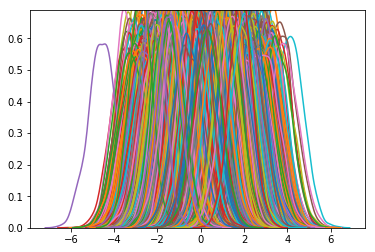

In [87]:
w0 = trace['w0']
i,j = 0,0
for j in range(w0.shape[2]):
    w = w0[:, 0, j]
    sns.kdeplot(w)
plt.show()

In [103]:
w0_sum = trace_summary[trace_summary.index.str.startswith('w0', na=False)]
w1_sum = trace_summary[trace_summary.index.str.startswith('w1', na = False)]
w2_sum = trace_summary[trace_summary.index.str.startswith('w2', na = False)]
b0_sum = trace_summary[trace_summary.index.str.startswith('b0', na = False)]
b1_sum = trace_summary[trace_summary.index.str.startswith('b1', na = False)]
b2_sum = trace_summary[trace_summary.index.str.startswith('b2', na = False)]

In [110]:
np.std(b1_sum['mean'])
np.mean(b1_sum['mean'])

-0.003418083047316017

In [111]:
def construct_nnet(nnt_input, nnt_out, hidden1, hidden2):
    """
    Data 
    ===========
    nnt_input: theano tensor shared variable 
        the input matrices converted into shared variable by theano.shared()
    
    nnt_out: shared variable
        the output matrix converted into shared variable by theano.shared()
        
    hidden1: int
        the number of perceptrons in hidden layer 1
    
    hidden2: int
        the number of perceptrons in hidden layer 2 
        
    K: int
        shape parameter in the gamma distribution for sigma2
        
    v: float
        sclae parameter in the gamma distribution for sigma2
        
    Parameters
    ==========
    sigma 2: float
        the error variance 
    
    w0, b0: float
        weight and bias from input to hidden layer 1
    
    w1, b1: float
        weight and bias from hidden layer 1 to hidden layer 2
    
    w2, b2: float
        weight and bias from hidden layer 2 to output 
    
    """
    K = 5 
    v = 0.2
    #K_share = theano.shared(K)
    #v_share = theano.shared(v)
    
    
    
    # initialize parameters
    sigma2 = np.random.gamma(shape=(0.05/K**(1/v))**2, scale=v, size=1).astype(floatX) 
    #sigma2 = np.random.gamma(shape = K, scale = v, size = 1).astype(floatX) 
    w0 = np.random.normal(loc = w0_sum['mean'], 
                          scale = np.sqrt(1.0/sigma2), size = (X_tr.shape[1], hidden1)).astype(floatX)
    b0 = np.random.normal(loc = b0_sum['mean'], 
                          scale = np.sqrt(1.0/sigma2), size = hidden1).astype(floatX) 
    w1 = np.random.normal(loc = w1_sum['mean'], 
                          scale = np.sqrt(1.0/sigma2), size = (hidden1, hidden2)).astype(floatX)
    b1 = np.random.normal(loc = b1_sum['mean'], 
                          scale = np.sqrt(1.0/sigma2), size = hidden2).astype(floatX)
    w2 = np.random.normal(loc = w2_sum['mean'], 
                          scale = np.sqrt(1.0/sigma2), size = (hidden2, 10)).astype(floatX)
    b2 = np.random.normal(loc = b2_sum['mean'], 
                          scale = np.sqrt(1.0/sigma2), size = 10).astype(floatX) 
    
    with pm.Model() as neural_net:
        
        # set prior for the parameters 
        s2 = pm.Gamma("s2", alpha = K, beta = v, shape = 1, testval = sigma2)
        weight_0 = pm.Normal("w0", 0, sd = T.sqrt(1.000001/s2),
                                     shape = (X_tr.shape[1], hidden1), testval = w0)
        weight_1 = pm.Normal("w1", 0, sd = T.sqrt(1.000001/s2),
                                     shape=(hidden1, hidden2), testval=w1)
        weight_2 = pm.Normal("w2", 0, sd = T.sqrt(1.000001/s2), 
                                    shape = (hidden2, 10), testval = w2)
        bias_0 = pm.Normal("b0",  0, sd = T.sqrt(1.000001/s2),
                                     shape=hidden1, testval=b0)
        bias_1 = pm.Normal("b1",  0, sd=T.sqrt(1.000001/s2),
                                 shape=hidden2, testval=b1)
        bias_2 = pm.Normal("b2",  0, sd=T.sqrt(1.000001/s2),
                                 shape=10, testval=b2) 
        
        # build neural network using tanh function
        act_1 = pm.math.tanh(pm.math.dot(nnt_input, weight_0) + bias_0)
        act_2 = pm.math.tanh(pm.math.dot(act_1, weight_1) + bias_1)
        act_mu = pm.math.dot(act_2, weight_2) + bias_2
        act_out = T.nnet.softmax(act_mu)
        
        # likelihood --> categorical likelihood 
        out = pm.Categorical("out",
                            act_out,
                            observed=nnt_out,
                            total_size=Y_tr.shape[0])
        
    return neural_net


In [ ]:
%%time

nnt_input = theano.shared(X_tr) # convert X_tr to shared variable 
nnt_out  = theano.shared(Y_tr) # convert Y_tr to shared Variable


# Run neural network with 150 neutrons
neural_network = construct_nnet(nnt_input, nnt_out, hidden1 = 150, hidden2 = 150)

from pymc3.backends import SQLite

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n = 6000, method = inference)
    #db = SQLite('trace.db')
    #trace_save = pm.sample(draws=3000, trace=db)